# Project 2: Wrangle and Analyze Data

## Data Gathering
In the cell below, i'm going to gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [71]:
import pandas as pd
import numpy as np

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [72]:
#read the twitter-archive-enhanced CSV file data into the DataFrame
df_1 = pd.read_csv('twitter-archive-enhanced.csv')   
#df_1.head()

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [73]:
#import the request library
import requests

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [8]:
#writing the content in local tsv file
open('image-predictions.tsv', 'wb').write(response.content)

335079

In [74]:
# Import the image predictions TSV file into a DataFrame
predictions = pd.read_csv('image-predictions.tsv', sep='\t')
#predictions.head()

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

#### API

In [ ]:
%false_Script%
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

#### Data to collect:

* Retweet count
* Favorite ("like") count
* Hashtags

In [75]:
tweet_json = []

# read in the json file line by line into a list
with open("tweet_json.txt") as file:
    for line in file:
        tweet_json.append(json.loads(line))

In [76]:
tweet_json[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'},
     'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'medium': {'w': 

In [77]:
# create a data frame containing the relevant api data
api_data = pd.DataFrame({'tweet_id': [i["id_str"] for i in tweet_json], 
     'retweet_count': [i["retweet_count"] for i in tweet_json], 
     'favorite_count': [i["favorite_count"] for i in tweet_json], 
     'hashtags': [i["entities"]["hashtags"] for i in tweet_json]})

## Assessing Data: Part 1

In [78]:
# Display the first 10 rows of the twitter-archive-enhanced DataFrame using .head
df_1.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [9]:
# Display the first 10 rows of the image predictions DataFrame
predictions.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [10]:
# Display the first 10 rows of the additional data DataFrame
api_data.head(10)

,tweet_id,retweet_count,favorite_count,hashtags
0,892420643555336193,8853,39467,[]
1,892177421306343426,6514,33819,[]
2,891815181378084864,4328,25461,[]
3,891689557279858688,8964,42908,[]
4,891327558926688256,9774,41048,"[{'text': 'BarkWeek', 'indices': [129, 138]}]"
5,891087950875897856,3261,20562,"[{'text': 'BarkWeek', 'indices': [129, 138]}]"
6,890971913173991426,2158,12041,[]
7,890729181411237888,16716,56848,[]
8,890609185150312448,4429,28226,"[{'text': 'BarkWeek', 'indices': [113, 122]}]"
9,890240255349198849,7711,32467,[]


### <font color='red'>Quality Issues:</font>

##### `archive and api data`
- both datasets still contain non-original tweets and tweets without images
- There are unneeded issues in the datasets
- expanded_urls sometimes contains multiple urls, which in at least some cases are identical
- hashtags column contains multiple hashtags
- wrong column type (timestamp should be date/time, some numerous columns need to be string, not numeric, and Hashtags column   will be better as boolean).
- no overall 'rating' for purposes of looking at which dogs rated highest (considering not all denominators are 10)
- name colum has too many values

#####  `predictions data`
- pictures are sometimes repeated; some appear to correspond to old retweets

##### `hashtags data`
- hashtags column includes bad formatting or irrelevant data

### <font color='red'>Tidiness Issues:</font>

- Tables must be joined at the end

##### `archive data & predictions Data`
- Type of dog [doggo, floofer, pupper, puppo] should be one column.



## Cleaning Data: Part 1

#### Making a copy of the original data before cleaning

In [79]:
archive_clean = df_1.copy()
predictions_clean = predictions.copy()
api_data_clean = api_data.copy()

In [80]:
archive_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [81]:
predictions_clean.head(10)
# predictions_clean.info()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [82]:
api_data_clean.head(10)
# api_data_clean.info()

,tweet_id,retweet_count,favorite_count,hashtags
0,892420643555336193,8853,39467,[]
1,892177421306343426,6514,33819,[]
2,891815181378084864,4328,25461,[]
3,891689557279858688,8964,42908,[]
4,891327558926688256,9774,41048,"[{'text': 'BarkWeek', 'indices': [129, 138]}]"
5,891087950875897856,3261,20562,"[{'text': 'BarkWeek', 'indices': [129, 138]}]"
6,890971913173991426,2158,12041,[]
7,890729181411237888,16716,56848,[]
8,890609185150312448,4429,28226,"[{'text': 'BarkWeek', 'indices': [113, 122]}]"
9,890240255349198849,7711,32467,[]


### Issue #1: Quality issue "archive and api dataset still contain non-original tweets and tweets without images"

#### - archive dataset still contains non-original tweets and tweets without images
#### Define
Remove all retweets and tweets without images from archive Dataset.

#### Code

In [83]:
# keeping only tweets that are not retweets
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]

#### Test

In [84]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [17]:
archive_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
750,779123168116150273,NaN,NaN,2016-09-23 01:00:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Reggie. He hugs everyone he meets. 12/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/779123168...,12,10,Reggie,None,None,None,None
508,812503143955202048,NaN,NaN,2016-12-24 03:40:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I'm happy to inform you all that Jake is in ex...,NaN,NaN,NaN,https://m.facebook.com/story.php?story_fbid=18...,13,10,None,None,None,None,None
1172,720389942216527872,NaN,NaN,2016-04-13 23:15:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ralphé. He patrols the lake. Looking f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/720389942...,11,10,Ralphé,None,None,None,None
329,833479644947025920,NaN,NaN,2017-02-20 00:53:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Poppy. She just arrived. 13/10 would s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/833479644...,13,10,Poppy,None,None,None,None
714,784057939640352768,NaN,NaN,2016-10-06 15:49:14 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Balto. He's very content. Legendary to...,NaN,NaN,NaN,https://vine.co/v/5gKxeUpuKEr,12,10,Balto,None,None,None,None
2327,666407126856765440,NaN,NaN,2015-11-17 00:06:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a southern Vesuvius bumblegruff. Can d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666407126...,7,10,a,None,None,None,None
1725,680070545539371008,NaN,NaN,2015-12-24 17:00:27 +0000,"<a href=""https://about.twitter.com/products/tw...",Say hello to Emmie. She's trapped in an orname...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680070545...,9,10,Emmie,None,None,None,None
1566,687841446767013888,NaN,NaN,2016-01-15 03:39:15 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",13/10 I can't stop watching this (vid by @k8ly...,NaN,NaN,NaN,https://vine.co/v/iOWwUPH1hrw,13,10,None,None,None,None,None
1489,692905862751522816,NaN,NaN,2016-01-29 03:03:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wally. He's being abducted by aliens. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692905862...,10,10,Wally,None,None,pupper,None
1668,682638830361513985,NaN,NaN,2015-12-31 19:05:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have no words. Just a magnificent pup. 12/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682638830...,12,10,None,None,None,None,None


#### - api dataset still contains non-original tweets and tweets without images

##### Define

Join api data to archive data, to ensure that it does not contain retweets or tweets without images.

##### Code

In [85]:
archive_clean.tweet_id = archive_clean.tweet_id.astype('str')

archive_clean = archive_clean.merge(api_data_clean, on="tweet_id", how="left")

##### Test

In [86]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   object 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

### Issue #2: Quality issue "There are unneeded issues in the datasets "

#### `Archive Data`

After removing retweets, the columns on retweet status are not useful anymore, and should be removed as well.

**Columns on retweet status are not useful after retweets are removed**

#### Define
Drop empty columns that contained information on retweets.

#### Code

In [87]:
archive_clean = archive_clean.drop(["retweeted_status_id",
                                    "retweeted_status_user_id",
                                    "retweeted_status_timestamp"], axis=1)

#### Test

In [88]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   object 
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
 14  retweet_count          2175 non-null   int64  
 15  favo

### Issue #3: Quality issue "archive_expanded_urls sometimes contains multiple urls "

#### Define
Check if url's are distinct . If so, then all should be kept. If not, remove duplicates. 
create additional column(s) to avoid multiple rows for each tweet.

#### Code

In [89]:
archive_clean["expanded_urls"] = archive_clean["expanded_urls"].astype(str)

In [90]:
#When the urls are not the same, they lead to external links, I will create a new column to store any external links.

archive_clean[["tweet_id","expanded_urls"]][archive_clean.expanded_urls.str.split(',').str.len() > 1]

# convert links to list and remove all duplicates
archive_clean.expanded_urls = archive_clean.expanded_urls.str.split(',').apply(set,).apply(list).str.join(',')
archive_clean.expanded_urls

0       https://twitter.com/dog_rates/status/892420643...
1       https://twitter.com/dog_rates/status/892177421...
2       https://twitter.com/dog_rates/status/891815181...
3       https://twitter.com/dog_rates/status/891689557...
4       https://twitter.com/dog_rates/status/891327558...
                              ...                        
2170    https://twitter.com/dog_rates/status/666049248...
2171    https://twitter.com/dog_rates/status/666044226...
2172    https://twitter.com/dog_rates/status/666033412...
2173    https://twitter.com/dog_rates/status/666029285...
2174    https://twitter.com/dog_rates/status/666020888...
Name: expanded_urls, Length: 2175, dtype: object

In [91]:
# extract all dog_rates tweets and put the in the local_url column
archive_clean["local_url"] = archive_clean.expanded_urls.str.extract("(https://twitter.com/dog_rates.+/1)")
# remove dog_rates tweets from what remains, and put that into a external_url column
archive_clean["external_url"] = archive_clean.expanded_urls.str.replace("(https://twitter.com/dog_rates/status/.+/.+/1)","", regex=True).str.strip(",").replace("", regex=True)

#### Test

In [92]:
archive_clean.info()
archive_clean[["expanded_urls","local_url","external_url"]].sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   object 
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2175 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
 14  retweet_count          2175 non-null   int64  
 15  favo

,expanded_urls,local_url,external_url
208,https://twitter.com/dog_rates/status/846153765...,https://twitter.com/dog_rates/status/846153765...,https://twitter.com/shomaristone/status/846484...
283,https://twitter.com/dog_rates/status/832636094...,https://twitter.com/dog_rates/status/832636094...,http://us.blastingnews.com/news/2017/02/jfk-an...
1376,https://twitter.com/dog_rates/status/688894073...,https://twitter.com/dog_rates/status/688894073...,https://vine.co/v/iOL792n5hz2
800,https://twitter.com/dog_rates/status/750041628...,https://twitter.com/dog_rates/status/750041628...,nan
124,https://twitter.com/dog_rates/status/864873206...,https://twitter.com/dog_rates/status/864873206...,https://twitter.com/nbcnews/status/86645871888...
1920,https://twitter.com/dog_rates/status/670717338...,https://twitter.com/dog_rates/status/670717338...,nan
35,https://twitter.com/dog_rates/status/884925521...,https://twitter.com/dog_rates/status/884925521...,https://twitter.com/4bonds2carbon/status/88551...
460,https://twitter.com/dog_rates/status/803638050...,https://twitter.com/dog_rates/status/803638050...,https://twitter.com/bvuepd/status/804417859124...
111,https://twitter.com/dog_rates/status/868622495...,https://twitter.com/dog_rates/status/868622495...,https://www.gofundme.com/help-fix-codys-torn-acl
1873,https://twitter.com/dog_rates/status/671486386...,https://twitter.com/dog_rates/status/671486386...,nan


### Issue #4: Quality issue "hashtags column contains multiple hashtags"

#### `Api_Data`

##### Define
I will check how many hashtags mentioned in a tweet.If they are more than one hashtag, i will create new separate table with hashtags.

#### Code

In [93]:
archive_clean[archive_clean.hashtags.str.len() != 0]
archive_clean[archive_clean.hashtags.str.len() > 1]

# there are tweets with more than one hashtag, but no tweets with more than two
archive_clean[archive_clean.hashtags.str.len() > 2]
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   object 
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2175 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
 14  retweet_count          2175 non-null   int64  
 15  favo

In [94]:
# create new hashtags table containing only tweet ID and hashtag. Only the tweets with hashtags.
hashtags = archive_clean[["tweet_id","hashtags"]]
hashtags = hashtags[hashtags.hashtags.str.len() > 0]

# the hashtags column may has a list of hashtags, now i will put them into multiple rows.
hashtags = pd.DataFrame({col:np.repeat(hashtags[col].values, hashtags["hashtags"].str.len())
              for col in hashtags.columns.difference(["hashtags"])
             }).assign(**{"hashtags":np.concatenate(hashtags["hashtags"].values)})[hashtags.columns.tolist()]

#### Test

In [95]:
hashtags.head(10)

,tweet_id,hashtags
0,891327558926688256,"{'text': 'BarkWeek', 'indices': [129, 138]}"
1,891087950875897856,"{'text': 'BarkWeek', 'indices': [129, 138]}"
2,890609185150312448,"{'text': 'BarkWeek', 'indices': [113, 122]}"
3,890006608113172480,"{'text': 'BarkWeek', 'indices': [121, 130]}"
4,889531135344209921,"{'text': 'BarkWeek', 'indices': [109, 118]}"
5,889278841981685760,"{'text': 'BarkWeek', 'indices': [129, 138]}"
6,881268444196462592,"{'text': 'Canada150', 'indices': [111, 121]}"
7,878776093423087618,"{'text': 'PrideMonthPuppo', 'indices': [29, 45]}"
8,878776093423087618,"{'text': 'PrideMonth', 'indices': [115, 126]}"
9,874012996292530176,"{'text': 'PrideMonth', 'indices': [122, 133]}"


## Assessing Data: Part 2

In [29]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   object 
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2175 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
 14  retweet_count          2175 non-null   int64  
 15  favo

In [30]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [31]:
hashtags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  26 non-null     object
 1   hashtags  26 non-null     object
dtypes: object(2)
memory usage: 544.0+ bytes


In [96]:
hashtags.hashtags

0           {'text': 'BarkWeek', 'indices': [129, 138]}
1           {'text': 'BarkWeek', 'indices': [129, 138]}
2           {'text': 'BarkWeek', 'indices': [113, 122]}
3           {'text': 'BarkWeek', 'indices': [121, 130]}
4           {'text': 'BarkWeek', 'indices': [109, 118]}
5           {'text': 'BarkWeek', 'indices': [129, 138]}
6          {'text': 'Canada150', 'indices': [111, 121]}
7      {'text': 'PrideMonthPuppo', 'indices': [29, 45]}
8         {'text': 'PrideMonth', 'indices': [115, 126]}
9         {'text': 'PrideMonth', 'indices': [122, 133]}
10    {'text': 'dogsatpollingstations', 'indices': [...
11          {'text': 'PrideMonth', 'indices': [66, 77]}
12          {'text': 'PrideMonth', 'indices': [39, 50]}
13        {'text': 'ScienceMarch', 'indices': [36, 49]}
14       {'text': 'K9VeteransDay', 'indices': [40, 54]}
15          {'text': 'WKCDogShow', 'indices': [26, 37]}
16        {'text': 'BellLetsTalk', 'indices': [42, 55]}
17         {'text': 'WomensMarch', 'indices': [6

## Cleaning Data: Part 2

### `Archive Data`

**Time of day tweet sent difficult to analyze, as not in own column**

##### Define
Create separate column for time, to make it possible to analyze if time tweet posted matters.

#### Code

In [97]:
# it seems that timestamp length is consistent, suggesting there are no obvious data quality issues
#archive[archive.timestamp.str.len() != 25]

temp = pd.DataFrame(archive_clean.timestamp.str.split(' ').tolist(), columns = ['date','time','offset'])

temp.offset.value_counts()
#adding the time column
archive_clean = archive_clean.join(temp[['time']])

#### Test

In [98]:
archive_clean.head()
archive_clean[["timestamp","time"]].sample(20)

,timestamp,time
123,2017-05-18 00:50:50 +0000,00:50:50
1111,2016-03-11 03:22:23 +0000,03:22:23
442,2016-12-12 00:29:28 +0000,00:29:28
282,2017-02-17 17:38:57 +0000,17:38:57
1231,2016-02-15 01:05:02 +0000,01:05:02
1758,2015-12-07 17:38:09 +0000,17:38:09
1759,2015-12-07 16:46:21 +0000,16:46:21
1061,2016-03-22 01:45:15 +0000,01:45:15
837,2016-06-27 00:07:44 +0000,00:07:44
1237,2016-02-13 22:29:29 +0000,22:29:29


In [18]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   object 
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2175 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
 14  retweet_count          2175 non-null   int64  
 15  favo

### Issue #5: Quality issue "wrong columns type"

### `Archive Data`

**<font color="green">timestamp and time columns</font>**

##### Define

The following columns need to be converted to date/time format:

* `timestamp`: change to date/time
* `time`: change to time

##### Code

In [99]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp, infer_datetime_format=True, utc=True)

In [100]:
archive_clean.time = pd.to_datetime(archive_clean.time).dt.time

#### Test

In [101]:
archive_clean.timestamp[0]
archive_clean.timestamp.value_counts()
archive_clean.info()
archive_clean.time[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2175 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2175 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

datetime.time(16, 23, 56)

**<font color="green">in_reply_to_status_id, in_reply_to_user_id, retweet_count and favorite_count columns</font>**

##### Define

The following columns need to be converted to the following formats:

* **in_reply_to_status_id** : change to string
* **in_reply_to_user_id**: change to string
* **retweet_count**: change to int
* **favorite_count**: change to int

##### Code

In [102]:
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.fillna(0).astype('int').astype('str').replace("0", np.nan)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.fillna(0).astype('int').astype('str').replace("0", np.nan)
archive_clean.retweet_count = archive_clean.retweet_count.fillna(0).astype('int')
archive_clean.favorite_count = archive_clean.favorite_count.fillna(0).astype('int')

##### Test

In [103]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     object             
 2   in_reply_to_user_id    78 non-null     object             
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2175 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2175 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

**<font color="green">hashtags column</font>**

##### Define

Add or convert columns to more straightforward true/false format (does the tweet contain hashtags or not).

* **hashtags**: change to boolean

##### Code

In [104]:
#I will change empty lists in hashtags column to NaN's, then i will change column value to whether it's empty, or not.
archive_clean.hashtags = ~archive_clean.hashtags.astype('str').replace("[]",np.nan).isnull()
archive_clean.hashtags = archive_clean.hashtags.astype('category')

##### Test

In [105]:
archive_clean.hashtags.value_counts()
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     object             
 2   in_reply_to_user_id    78 non-null     object             
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2175 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2175 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

### `predictions Data`

**<font color="green">tweet ID column</font>**

##### Define

Convert column to string format.

##### Code

In [106]:
predictions_clean.tweet_id = predictions_clean.tweet_id.astype('str')

##### Test

In [107]:
predictions_clean.info()
predictions_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue #6: quality issue "no overall rating to see which dogs rated highest"

#### Define
- no overall 'rating' for purposes of looking at which dogs rated highest (considering not all denominators are 10)
- create column for overall 'rating' of dog

##### Code

In [108]:
archive_clean["overall_rating"] = archive_clean.rating_numerator/archive_clean.rating_denominator

##### Test

In [109]:
archive_clean[["rating_numerator", "rating_denominator", "overall_rating"]]

,rating_numerator,rating_denominator,overall_rating
0,13,10,1.3
1,13,10,1.3
2,12,10,1.2
3,13,10,1.3
4,12,10,1.2
...,...,...,...
2170,5,10,0.5
2171,6,10,0.6
2172,9,10,0.9
2173,7,10,0.7


### Issue #7: Quality issue "name column has too many values"

##### Define
Create new column for whether **name** used at all

##### Code

In [110]:
archive_clean["name_used"] = archive_clean.name!="None"

##### Test

In [111]:
archive_clean.name_used.value_counts()
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     object             
 2   in_reply_to_user_id    78 non-null     object             
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2175 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2175 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

### Issue #8: Quality issue "pictures are sometimes repeated; some appear to correspond to old retweets"

#### Define
Keep only those tweet ID's which are found in tweet archive.

##### Code

In [112]:
predictions_clean = predictions_clean[predictions_clean.tweet_id.isin(archive_clean.tweet_id)]

##### Test

In [113]:
predictions_clean.jpg_url.value_counts()
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1994 non-null   object 
 1   jpg_url   1994 non-null   object 
 2   img_num   1994 non-null   int64  
 3   p1        1994 non-null   object 
 4   p1_conf   1994 non-null   float64
 5   p1_dog    1994 non-null   bool   
 6   p2        1994 non-null   object 
 7   p2_conf   1994 non-null   float64
 8   p2_dog    1994 non-null   bool   
 9   p3        1994 non-null   object 
 10  p3_conf   1994 non-null   float64
 11  p3_dog    1994 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 161.6+ KB


### Issue #9: Quality issue "hashtags column includes bad formatting or irrelevant data"

#### Define
Get rid of irrelevant text in column.

#### Code

In [114]:
hashtags.hashtags = hashtags.hashtags.astype('str').str.extract(r"'text': '(.+)', ")

#### Test

In [115]:
hashtags.hashtags.value_counts()
hashtags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  26 non-null     object
 1   hashtags  26 non-null     object
dtypes: object(2)
memory usage: 544.0+ bytes


### Tidiness Issue #1: "Dog stages need to be combined into one column"

#### `archive data & predictions Data`

#### Define

Make one column that includes the types of dog.

#### Code

In [116]:
#showing only the rows with multiple dog stages.
archive_clean.loc[(archive_clean[['doggo', 'floofer', 'pupper', 'puppo']] != 'None'
                 ).sum(axis=1) > 1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,pupper,puppo,retweet_count,favorite_count,hashtags,local_url,external_url,time,overall_rating,name_used
165,855851453814013952,NaN,NaN,2017-04-22 18:31:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,None,...,None,puppo,19196,47844,True,https://twitter.com/dog_rates/status/855851453...,https://twitter.com/perfy/status/8558573181681...,18:31:02,1.3,False
172,854010172552949760,NaN,NaN,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11,10,None,...,None,None,3433,17169,False,https://twitter.com/dog_rates/status/854010172...,https://twitter.com/markhalperin/status/855656...,16:34:26,1.1,False
382,817777686764523521,NaN,NaN,2017-01-07 16:59:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,...,pupper,None,3084,11901,False,https://twitter.com/dog_rates/status/817777686...,https://twitter.com/micahgrimes/status/8179020...,16:59:28,1.3,True
442,808106460588765185,NaN,NaN,2016-12-12 00:29:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,None,...,pupper,None,2525,9701,False,https://twitter.com/dog_rates/status/808106460...,https://vine.co/v/5QWd3LZqXxd,00:29:28,1.2,False
467,802265048156610565,-2147483648,-2147483648,2016-11-25 21:37:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",https://twitter.com/dog_rates/status/802265048...,11,10,None,...,pupper,None,1573,7039,False,https://twitter.com/dog_rates/status/802265048...,https://vine.co/v/5FwUWjYaW0Y,21:37:47,1.1,False
474,801115127852503040,NaN,NaN,2016-11-22 17:28:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,...,pupper,None,2429,8992,False,https://twitter.com/dog_rates/status/801115127...,nan,17:28:25,1.2,True
567,785639753186217984,NaN,NaN,2016-10-11 00:34:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,...,pupper,None,2561,8735,False,https://twitter.com/dog_rates/status/785639753...,nan,00:34:48,1.0,True
593,781308096455073793,NaN,NaN,2016-09-29 01:42:20+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",https://vine.co/v/5rgu2Law2ut,12,10,None,...,pupper,None,2961,7973,False,NaN,https://vine.co/v/5rgu2Law2ut,01:42:20,1.2,False
722,759793422261743616,NaN,NaN,2016-07-31 16:50:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,...,pupper,None,2173,6620,False,https://twitter.com/dog_rates/status/759793422...,https://vine.co/v/5AJm5pq7Kav,16:50:42,1.2,True
781,751583847268179968,NaN,NaN,2016-07-09 01:08:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,https://twitter.com/dog_rates/status/751583847...,5,10,None,...,pupper,None,1265,4849,False,https://twitter.com/dog_rates/status/751583847...,https://vine.co/v/5W5YHdTJvaV,01:08:47,0.5,False


In [117]:
archive_clean.doggo.replace('None', '', inplace=True)
archive_clean.doggo.replace(np.NaN, '', inplace=True)

In [118]:
archive_clean['stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo
archive_clean.loc[archive_clean.stage == 'doggopupper', 'stage'] = 'doggo,pupper'
archive_clean.loc[archive_clean.stage == 'doggopuppo', 'stage'] = 'doggo,puppo'
archive_clean.loc[archive_clean.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'

#### Test

In [119]:
archive_clean.stage.value_counts()

NoneNoneNone            1831
NonepupperNone           224
doggoNoneNoneNone         75
NoneNonepuppo             24
doggoNonepupperNone       10
flooferNoneNone            9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: stage, dtype: int64

In [120]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     object             
 2   in_reply_to_user_id    78 non-null     object             
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2175 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2175 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

**<font color="Red"><h3>no columns in archive for most likely dog and confidence</h3></font>**
##### Define
Join `predictions` table to `archive` and create a columns for the most likely dog and confidence.

#### Code

In [121]:
archive_clean = archive_clean.merge(predictions_clean[["tweet_id","p1","p1_conf","p1_dog"]], on="tweet_id", how="left")

#### Test

In [122]:
# archive_clean.info()
archive_clean.p1.value_counts()
# archive_clean.p1_conf.describe()

golden_retriever      139
Labrador_retriever     95
Pembroke               88
Chihuahua              79
pug                    54
                     ... 
nail                    1
timber_wolf             1
espresso                1
bib                     1
desktop_computer        1
Name: p1, Length: 374, dtype: int64

### Tidiness Issue #2: "join the three tables in one"

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [124]:
archive_clean.to_csv("twitter_archive_master.csv", index=False)
predictions_clean.to_csv("image_predictions.csv", index=False)
hashtags.to_csv("hashtags.csv", index=False)

## Analyzing and Visualizing Data
In this section, I will analyze and visualize my wrangled data.

### Time Series

* likes and retweets over time
* ratings over time
* likes and retweets by time of day

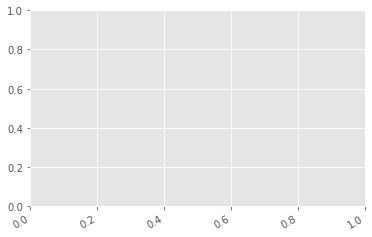

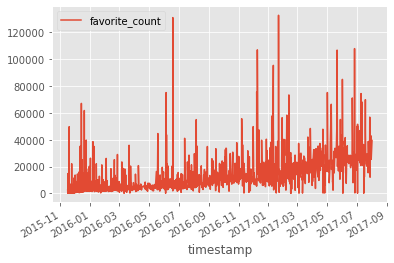

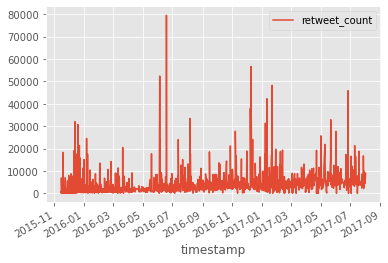

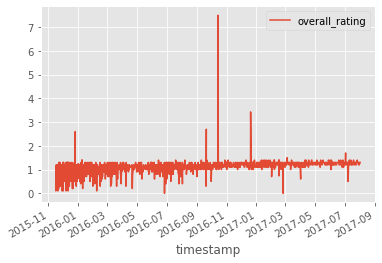

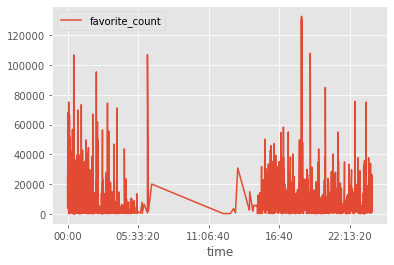

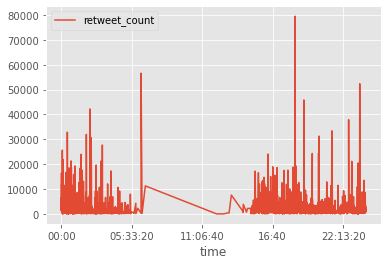

In [125]:
#above is the line i deleted, fig should be declared.
fig, axs = plt.subplots()

archive_clean.plot("timestamp", "favorite_count")
fig.autofmt_xdate()

archive_clean.plot("timestamp", "retweet_count")
fig.autofmt_xdate()
### favorites clearly increased over time; retweets may have increased slightly

archive_clean[archive_clean.overall_rating<10].plot('timestamp', 'overall_rating')
fig.autofmt_xdate()
### after filtering out unusually high ratings, ratings have clearly increased over time

archive_clean.plot('time', y='favorite_count')
fig.autofmt_xdate()

archive_clean.plot('time', y='retweet_count')
fig.autofmt_xdate()
### retweets and favorites may be somewhat higher in the morning and evening, but this is not as interesting.

### Bar Plots

* likes and retweets by dog
* ratings by dog 

<AxesSubplot:title={'center':'overall_rating'}, xlabel='p1'>

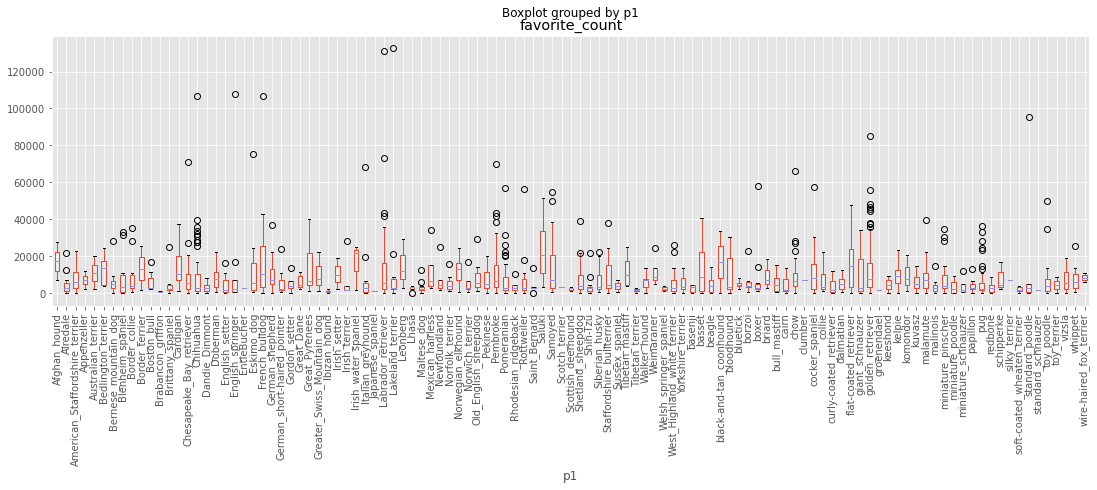

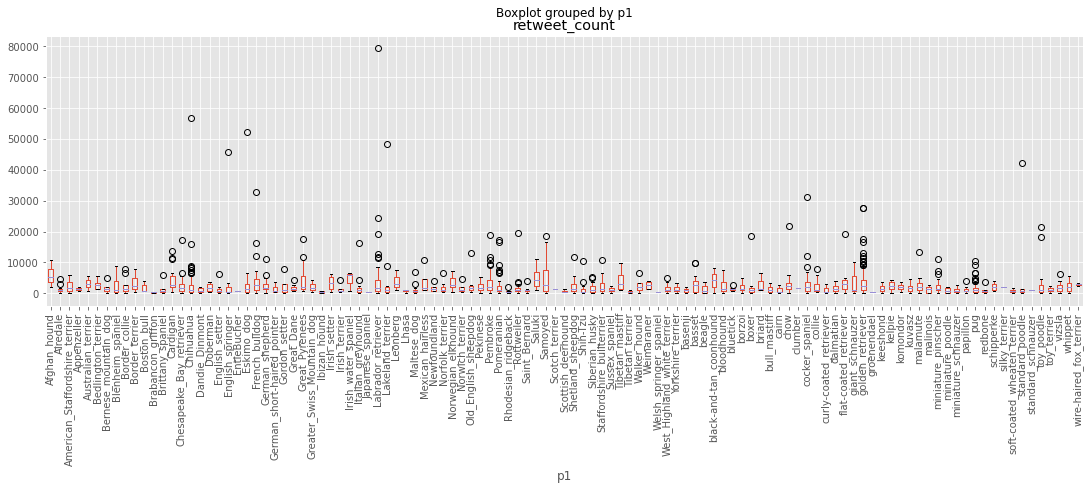

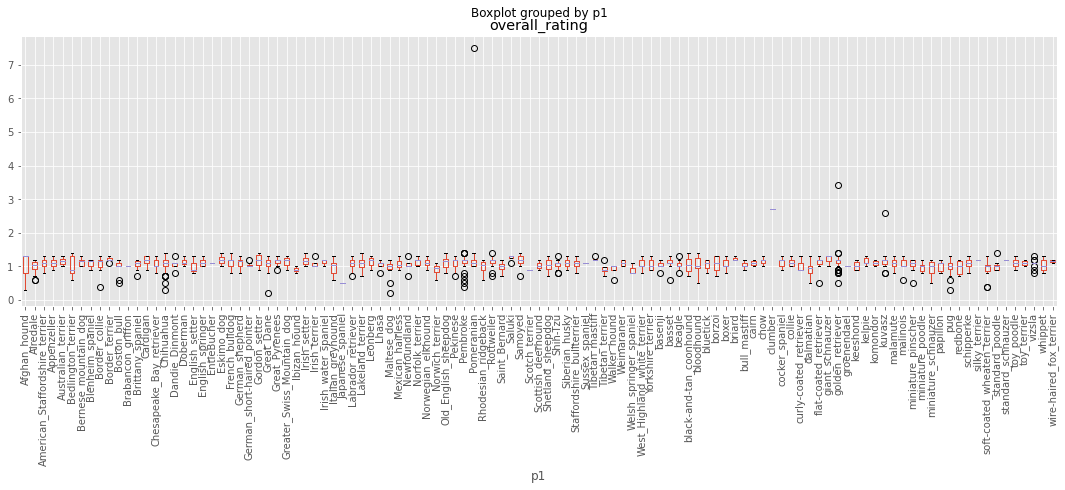

In [126]:
archive_clean[archive_clean.p1_dog==True].boxplot('favorite_count', 'p1', figsize=(18,  5), rot=90)

archive_clean[archive_clean.p1_dog==True].boxplot('retweet_count', 'p1', figsize=(18,  5), rot=90)
### there are differences between dogs, but it's not clear if they are particularly significant
### in any case, it may be worth seeing which dogs are most highly rated in a sorted bar plot

archive_clean[archive_clean.p1_dog==True].boxplot('overall_rating', 'p1', figsize=(18,  5), rot=90)

### Scatterplots
* likes and retweets by dog rating

<AxesSubplot:xlabel='overall_rating', ylabel='retweet_count'>

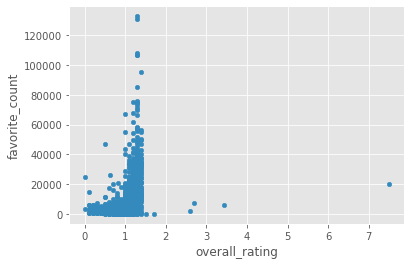

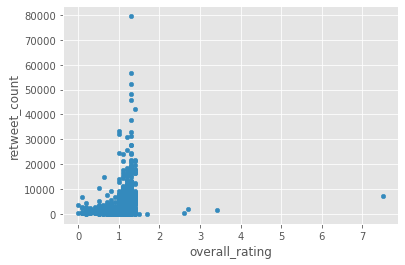

In [127]:
archive_clean[archive_clean.overall_rating<10].plot.scatter(x="overall_rating", y="favorite_count")

archive_clean[archive_clean.overall_rating<10].plot.scatter(x="overall_rating", y="retweet_count")

### the higher the rating, the more retweets and favorites, although this may be confounded by time

### Favorites, Retweets, and Ratings over Time

<Figure size 432x288 with 0 Axes>

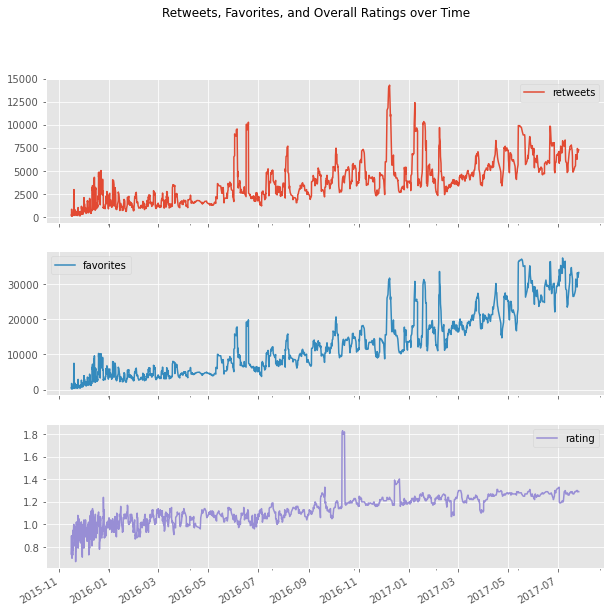

In [128]:
plt.clf()

# make time stamp index
temp = archive_clean[archive_clean.overall_rating<10][["timestamp",
                                                       "retweet_count",
                                                       "favorite_count",
                                                       "overall_rating"]].set_index("timestamp").rename_axis(None)

# average out retweets, favorites, and ratings over 10 instances, to get a smoother line
time = pd.DataFrame({"retweets": temp.retweet_count.rolling(10).mean(), 
                     "favorites": temp.favorite_count.rolling(10).mean(),
                     "rating": temp.overall_rating.rolling(10).mean()})

fig = time.plot(subplots=True, figsize=(10,10), title="Retweets, Favorites, and Overall Ratings over Time")
#saving the picture
#plt.savefig('plots/time.png', bbox_inches='tight')

### Favorites, Retweets, and Ratings by Dog Breed

Text(0.5, 1.0, 'Most Highly Rated Dogs')

<Figure size 432x288 with 0 Axes>

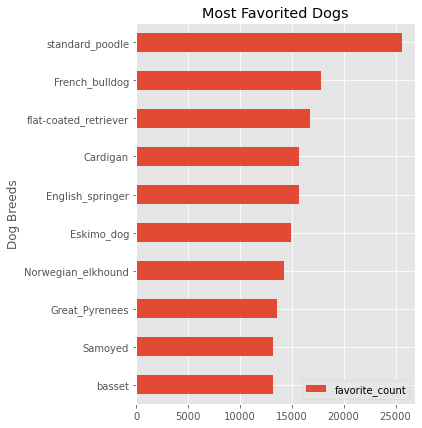

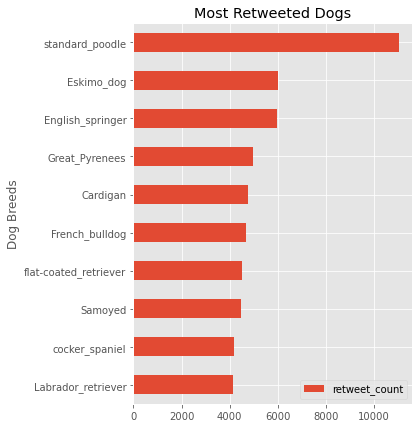

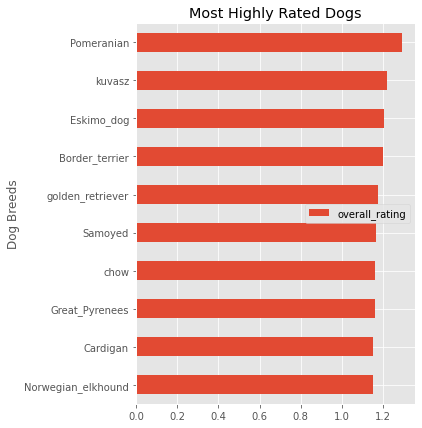

In [129]:
plt.clf()

# see which dog breeds were mentioned more than 5 times.
multiple_posts = archive_clean[archive_clean.p1_dog==True].groupby('p1')['tweet_id'].count()
multiple_posts = list(multiple_posts[multiple_posts>5].reset_index().p1)

# filter out outlier high ratings, non-dogs, very low picture confience, and dog breeds infrequently mentioned
dog_breed = archive_clean[(archive_clean.p1_dog==True) & 
              (archive_clean.overall_rating<10) &
              (archive_clean.p1.isin(multiple_posts)) &
              (archive_clean.p1_conf>0.3)].groupby('p1')["favorite_count"].mean().reset_index().sort_values('favorite_count', ascending=True).set_index('p1')
fig = dog_breed.tail(10).head(10).plot.barh(figsize=(5,7))
fig.set_ylabel("Dog Breeds")
fig.set_title("Most Favorited Dogs")
#plt.savefig('plots/favorited_dogs.png', bbox_inches='tight')

dog_breed = archive_clean[(archive_clean.p1_dog==True) & 
              (archive_clean.overall_rating<10) &
              (archive_clean.p1.isin(multiple_posts)) &
              (archive_clean.p1_conf>0.3)].groupby('p1')["retweet_count"].mean().reset_index().sort_values('retweet_count', ascending=True).set_index('p1')
fig = dog_breed.tail(10).plot.barh(figsize=(5,7))
fig.set_ylabel("Dog Breeds")
fig.set_title("Most Retweeted Dogs")
#plt.savefig('plots/retweeted_dogs.png', bbox_inches='tight')

dog_breed = archive_clean[(archive_clean.p1_dog==True) & 
              (archive_clean.overall_rating<10) &
              (archive_clean.p1.isin(multiple_posts)) &
              (archive_clean.p1_conf>0.3)].groupby('p1')["overall_rating"].mean().reset_index().sort_values('overall_rating', ascending=True).set_index('p1')
fig = dog_breed.tail(10).head(10).plot.barh(figsize=(5,7))
fig.set_ylabel("Dog Breeds")
fig.set_title("Most Highly Rated Dogs")
#plt.savefig('plots/rated_dogs.png', bbox_inches='tight')


### Favorites by Dog Rating

Text(0.5, 1.0, 'Favorites by Dog Rating')

<Figure size 432x288 with 0 Axes>

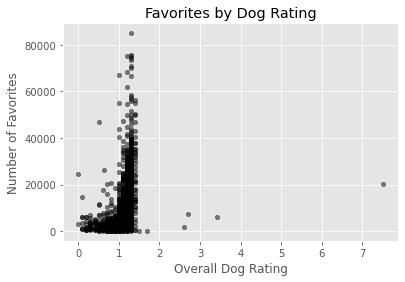

In [132]:
plt.clf()
dog_rating = archive_clean[["overall_rating","favorite_count"]]
noise = np.random.normal(1, 0.05, len(dog_rating.overall_rating))

# filter out outlier high ratings, outlier high favorites
fig = dog_rating[(dog_rating.overall_rating<10) &
           (dog_rating.favorite_count<90000)].plot.scatter("overall_rating", 
                   "favorite_count", alpha=0.5, color="black")
fig.set_xlabel("Overall Dog Rating")
fig.set_ylabel("Number of Favorites")
fig.set_title("Favorites by Dog Rating")
#plt.savefig('plots/favorites_rating.png', bbox_inches='tight')